In [3]:
import numpy as np
import pandas as pd
import logging
import sys
from graph.graph import AssociatedGraph
from utils.preprocessing import create_graphs, calculate_residue_depth
from config import make_graph_config
import argparse
from os import path
from graph.graph import Graph
from itertools import combinations

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
def generate_ca_combinations(central_node, neighbors, pos=1):
    """
    Gera combinações para calcular ângulos entre carbonos alfa.

    Parâmetros:
    - central_node (tuple): Nó central no formato ('Chain:Residue:ResidueNumber', 'Chain:Residue:ResidueNumber')
    - neighbors (list of tuples): Lista de vizinhos no mesmo formato do nó central

    Retorna:
    - list: Lista de strings formatadas para seleção dos carbonos alfa
    """
    central_residue = central_node[pos-1].split(':')  # Pegamos um dos pares, pois ambos são iguais
    central_chain = central_residue[0]
    central_number = central_residue[2]
    neighbor_combinations = combinations(neighbors, 2)

    selections = [
        f"#1/{central_chain}:{central_number}@CA/{n1[pos-1].split(':')[0]}:{n1[pos-1].split(':')[2]}@CA/{n2[pos-1].split(':')[0]}:{n2[pos-1].split(':')[2]}@CA"
        for n1, n2 in neighbor_combinations
    ]

    return selections

def analysis_rsa_depth(g, residue_depth):
    residue_depth['ResidueNumber'] = residue_depth['ResidueNumber'].astype(int)

    rsa_df = g.graph.graph["dssp_df"]["rsa"].reset_index()
    split_data = rsa_df['node_id'].str.split(':', expand=True)

    # Extrair Chain, ResidueName e ResidueNumber (garantindo conversão segura para números)
    rsa_df['Chain'] = split_data[0]  # Já é string (object)
    rsa_df['ResidueName'] = split_data[1]
    rsa_df['ResidueNumber'] = pd.to_numeric(split_data[2], errors='coerce')  # Converte para float, trata erros

    # Remover linhas com ResidueNumber inválido (NaN)
    rsa_df = rsa_df.dropna(subset=['ResidueNumber'])
    rsa_df['ResidueNumber'] = rsa_df['ResidueNumber'].astype(int)  # Converte para int

    # Selecionar colunas relevantes
    rsa_df = rsa_df[['Chain', 'ResidueNumber', 'rsa']]

    merged_df = residue_depth.merge(
        rsa_df,
        on=['Chain', 'ResidueNumber'],
        how='inner'  # Manter apenas resíduos presentes em ambos
    )

    return merged_df


def min_max_rsa_depth(merged_df):
    # Criar uma nova coluna com a soma de ResidueDepth e rsa
    merged_df['sum'] = merged_df['ResidueDepth'] + merged_df['rsa']

    # Seleção dos 10 resíduos com as menores somas de RSA e Depth
    min_sum_residues = merged_df.nsmallest(10, 'sum')

    # Seleção dos 10 resíduos com as maiores somas de RSA e Depth
    max_sum_residues = merged_df.nlargest(10, 'sum')

    # Seleção dos 10 resíduos com os maiores valores de Depth e menores valores de RSA
    max_depth_min_rsa = merged_df.nlargest(30, 'ResidueDepth').nsmallest(10, 'rsa')

    # Seleção dos 10 resíduos com os maiores valores de RSA e menores valores de Depth
    max_rsa_min_depth = merged_df.nlargest(30, 'rsa').nsmallest(10, 'ResidueDepth')

    return min_sum_residues, max_sum_residues, max_depth_min_rsa, max_rsa_min_depth

In [5]:
def numbers_to_ranges(numbers):
    if not numbers:
        return []
    numbers_int = [int(num) for num in numbers]
    sorted_numbers = sorted(numbers_int)
    ranges = []
    start = sorted_numbers[0]
    end = start
    for num in sorted_numbers[1:]:
        if num == end + 1:
            end = num
        else:
            ranges.append(f"{start}-{end}" if start != end else str(start))
            start = num
            end = num
    ranges.append(f"{start}-{end}" if start != end else str(start))
    return ranges

def generate_chimerax_selection(df, model_number=1):
    # Agrupa resíduos por cadeia e converte números em intervalos
    grouped = df.groupby('Chain')['ResidueNumber'].apply(list).to_dict()
    chain_parts = []
    for chain in sorted(grouped.keys()):  # Ordena as cadeias alfabeticamente
        numbers = grouped[chain]
        ranges = numbers_to_ranges(numbers)
        if ranges:
            chain_part = f"{chain}:" + ",".join(ranges)
            chain_parts.append(chain_part)
    if not chain_parts:
        return ""
    return f"#{model_number}/" + "/".join(chain_parts)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

def plot_correlation_rsa_depth(merged_df, remove_outliers=False, max_rsa=None, max_depth=None):
    df = merged_df.copy()

    # Filtrar valores máximos, se especificados
    if max_rsa is not None:
        df = df[df['rsa'] <= max_rsa]
    if max_depth is not None:
        df = df[df['ResidueDepth'] <= max_depth]

    # Remover outliers se necessário (usando IQR)
    if remove_outliers:
        Q1 = df[['ResidueDepth', 'rsa']].quantile(0.25)
        Q3 = df[['ResidueDepth', 'rsa']].quantile(0.75)
        IQR = Q3 - Q1

        df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

    # Calcular correlação
    if len(df) > 1:  # Garante que haja dados suficientes para o cálculo
        corr, p_value = pearsonr(df['ResidueDepth'], df['rsa'])
    else:
        corr, p_value = np.nan, np.nan  # Evita erro se não houver dados suficientes

    # Criar o gráfico
    plt.figure(figsize=(10, 6))
    sns.regplot(
        x='ResidueDepth',
        y='rsa',
        data=df,
        scatter_kws={'alpha': 0.5},
        line_kws={'color': 'red'}
    )

    plt.title(f'Correlação ResidueDepth vs RSA (r = {corr:.3f}, p = {p_value:.2e})')
    plt.xlabel('Residue Depth')
    plt.ylabel('RSA')
    plt.grid(True)
    plt.show()

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Subgraph exposed_residues created with success!
Subgraph selected_chains created with success!
Subgraph all_residues created with success!


/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Subgraph exposed_residues created with success!
Subgraph selected_chains created with success!
Subgraph all_residues created with success!
DEBUG:CRSProtein:Total Lenght Graphs: 107
INFO:CRSProtein:Creating filtered contact maps and full residue maps...
INFO:CRSProtein:Filtered contact maps and full residue maps created with success!
DEBUG:CRSProtein:RSA MAP: [array([0.30645161, 0.35858586, 0.58895706, 0.56585366, 0.64948454,
       0.47317073, 0.47317073, 0.45876289, 0.60869565, 0.29761905,
       0.36619718, 0.63131313, 0.51190476, 0.33098592, 0.64646465,
       0.49112426, 0.3452381 , 0.73584906, 0.75352113, 0.7371134 ,
       0.19823789, 0.12886598, 0.23857868, 0.38679245, 0.71649485,
       0.28787879, 0.56854839, 0.5       , 0.49112426, 0.33467742,
       0.44785276, 0.72580645, 0.47239264, 0.47983871, 0.82352941,
       0.41935484, 0.14084507, 0.41666667, 0.10191083, 0.5       ,
       0.30882353, 0.2972973 , 0.60606061, 0.54761905, 0.51408451,
       0.75      , 0.67171717, 0.16

/home/carlos23001/IC/pMHC_graph/utils/tools.py:1232: RuntimeWarning: divide by zero encountered in divide
  mult = 1 / (np.array(adj) * np.array(dist_m))
/home/carlos23001/IC/pMHC_graph/utils/tools.py:1232: RuntimeWarning: divide by zero encountered in divide
  mult = 1 / (np.array(adj) * np.array(dist_m))


INFO:CRSProtein:Filtered combinations successfully made! Found 115 / 115 valid edges.
DEBUG:CRSProtein:Reference Graph Indices [0, 21, 27, 32, 49, 25, 29, 38, 40, 26, 7, 20, 24, 34, 1, 4, 8, 18, 28, 35, 44, 45, 17, 48, 23, 51, 6, 2, 22, 3, 5, 14, 30, 36, 42, 47, 33, 39, 50, 15, 31, 13, 41, 52]
DEBUG:CRSProtein:Chain_id: A, color: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
DEBUG:CRSProtein:Chain_id: C, color: (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
INFO:CRSProtein:Association product computed in 1.32 seconds


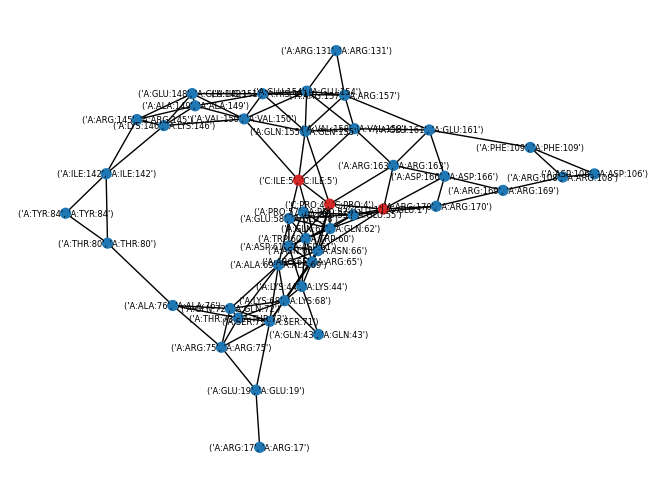

INFO:CRSProtein:GraphAssociated's plot saved in data/tests/full_association_graph_test.png


<Figure size 640x480 with 0 Axes>

In [3]:
args = argparse.Namespace(
    folder_path='pdb_input',
    files_name='pmhc_titin_5bs0_renumber.pdb,pmhc_mage3_5brz_renumber.pdb',
    reference_graph=None,
    centroid_threshold=10,
    run_name='test',
    association_mode='similarity',
    output_path='data/tests',
    neighbor_similarity_cutoff=0.8,
    residues_similarity_cutoff=0.8,
    factors_path='resources/atchley_aa.csv',
    rsa_filter=0.1,
    depth_similarity_threshold=0.8,
    rsa_similarity_threshold=0.8,
    residues_lists='residues_lists.json',
    serd_file=None,
    debug=True,
    angle_diff=20.0
)

logging.getLogger('matplotlib').setLevel(logging.ERROR)
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG if args.debug else logging.INFO)
log = logging.getLogger("CRSProtein")
log.setLevel(logging.DEBUG if args.debug else logging.INFO)

graphs, reference_graph = create_graphs(args)

G = AssociatedGraph(
    graphs=graphs,
    reference_graph=reference_graph,
    output_path=args.output_path,
    path_full_subgraph=path.join(args.output_path, f"full_association_graph_{args.run_name}.png"),
    association_mode=args.association_mode,
    factors_path=args.factors_path,
    run_name=args.run_name,
    centroid_threshold=args.centroid_threshold,
    residues_similarity_cutoff=args.residues_similarity_cutoff,
    neighbor_similarity_cutoff=args.neighbor_similarity_cutoff,
    rsa_similarity_threshold=args.rsa_similarity_threshold,
    depth_similarity_threshold=args.depth_similarity_threshold,
    angle_diff=args.angle_diff,
)


G.draw_graph(show = True)

G.grow_subgraph_bfs()

In [10]:
list(G.associated_graph.nodes)

[('A:ARG:170', 'A:ARG:170'),
 ('C:GLU:1', 'C:GLU:1'),
 ('A:ARG:169', 'A:ARG:169'),
 ('A:ASP:166', 'A:ASP:166'),
 ('A:GLU:55', 'A:GLU:55'),
 ('A:GLN:62', 'A:GLN:62'),
 ('A:ARG:163', 'A:ARG:163'),
 ('A:ASN:66', 'A:ASN:66'),
 ('C:PRO:4', 'C:PRO:4'),
 ('A:ARG:108', 'A:ARG:108'),
 ('A:GLU:161', 'A:GLU:161'),
 ('A:TRP:60', 'A:TRP:60'),
 ('A:GLU:58', 'A:GLU:58'),
 ('A:PRO:57', 'A:PRO:57'),
 ('A:GLN:155', 'A:GLN:155'),
 ('A:GLU:154', 'A:GLU:154'),
 ('A:HIS:151', 'A:HIS:151'),
 ('A:VAL:158', 'A:VAL:158'),
 ('C:ILE:5', 'C:ILE:5'),
 ('A:ARG:157', 'A:ARG:157'),
 ('A:VAL:150', 'A:VAL:150'),
 ('A:ARG:131', 'A:ARG:131'),
 ('A:ALA:149', 'A:ALA:149'),
 ('A:GLU:148', 'A:GLU:148'),
 ('A:ALA:69', 'A:ALA:69'),
 ('A:ARG:65', 'A:ARG:65'),
 ('A:LYS:146', 'A:LYS:146'),
 ('A:ASP:106', 'A:ASP:106'),
 ('A:PHE:109', 'A:PHE:109'),
 ('A:LYS:44', 'A:LYS:44'),
 ('A:LYS:68', 'A:LYS:68'),
 ('A:GLN:43', 'A:GLN:43'),
 ('A:ASP:61', 'A:ASP:61'),
 ('A:THR:73', 'A:THR:73'),
 ('A:GLN:72', 'A:GLN:72'),
 ('A:SER:71', 'A:SER:71')

In [7]:
G.graphs[0][0].residue_depth

,ResidueNumber,Chain,ResidueDepth
0,2,A,0.121842
1,3,A,0.087852
2,4,A,0.092305
3,6,A,0.114948
4,8,A,0.080320
...,...,...,...
139,4,C,0.110722
140,5,C,0.076086
141,6,C,0.115501
142,7,C,0.193876


/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Subgraph exposed_residues created with success!
Subgraph selected_chains created with success!
Subgraph all_residues created with success!


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Subgraph exposed_residues created with success!
Subgraph selected_chains created with success!
Subgraph all_residues created with success!
DEBUG:CRSProtein:Total Lenght Graphs: 107
INFO:CRSProtein:Creating filtered contact maps and full residue maps...
INFO:CRSProtein:Filtered contact maps and full residue maps created with success!
INFO:CRSProtein:Creating the Neighbors Vector...
INFO:CRSProtein:Neighbors vector created with success!
INFO:CRSProtein:Creating neighbors similarity matrix...
INFO:CRSProtein:Neighbors similarity matrix created with success!
INFO:CRSProtein:Creating RSA similarity matrix...
INFO:CRSProtein:RSA similarity matrix created with success!
INFO:CRSProtein:Creating Depth similarity matrix...
INFO:CRSProtein:Depth similarity matrix created with success!
INFO:CRSProtein:Similarity: Creating associated nodes matrix...
INFO:CRSProtein:Similarity: Associated nodes matrix created with success!
DEBUG:CRSProtein:Dimension of Associated Matrix: (107, 107)
DEBUG:CRSProtein:

/home/carlos23001/IC/pMHC_graph/utils/tools.py:1228: RuntimeWarning: divide by zero encountered in divide
  mult = 1 / (np.array(adj) * np.array(dist_m))
/home/carlos23001/IC/pMHC_graph/utils/tools.py:1228: RuntimeWarning: divide by zero encountered in divide
  mult = 1 / (np.array(adj) * np.array(dist_m))


INFO:CRSProtein:Filtered combinations successfully made! Found 115 / 115 valid edges.
DEBUG:CRSProtein:Reference Graph Indices [0, 15, 17, 2, 23, 43, 52, 22, 1, 5, 11, 14, 35, 37, 38, 40, 44, 36, 50, 3, 31, 33, 42, 24, 46, 47, 20, 32, 4, 8, 6, 7, 12, 16, 28, 10, 26, 18, 25, 27, 39, 48, 13, 19]
DEBUG:CRSProtein:Chain_id: A, color: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
DEBUG:CRSProtein:Chain_id: C, color: (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
INFO:CRSProtein:Association product computed in 1.33 seconds


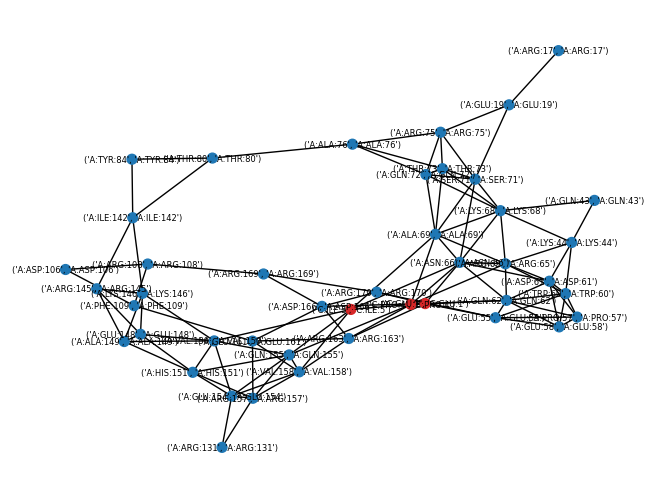

INFO:CRSProtein:GraphAssociated's plot saved in data/tests/full_association_graph_test.png


<Figure size 640x480 with 0 Axes>

In [9]:
args = argparse.Namespace(
    folder_path='pdb_input',
    files_name='pmhc_titin_5bs0_renumber.pdb,pmhc_mage3_5brz_renumber.pdb',
    reference_graph=None,
    centroid_threshold=10,
    run_name='test',
    association_mode='similarity',
    output_path='data/tests',
    neighbor_similarity_cutoff=0.8,
    residues_similarity_cutoff=0.8,
    factors_path='resources/atchley_aa.csv',
    rsa_filter=0.1,
    depth_similarity_threshold=0.8,
    rsa_similarity_threshold=0.8,
    residues_lists='residues_lists.json',
    serd_config=None,
    debug=True,
    angle_diff=20.0
)

logging.getLogger('matplotlib').setLevel(logging.ERROR)
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG if args.debug else logging.INFO)
log = logging.getLogger("CRSProtein")
log.setLevel(logging.DEBUG if args.debug else logging.INFO)

graphs, reference_graph = create_graphs(args)

G = AssociatedGraph(
    graphs=graphs,
    reference_graph=reference_graph,
    output_path=args.output_path,
    path_full_subgraph=path.join(args.output_path, f"full_association_graph_{args.run_name}.png"),
    association_mode=args.association_mode,
    factors_path=args.factors_path,
    run_name=args.run_name,
    centroid_threshold=args.centroid_threshold,
    residues_similarity_cutoff=args.residues_similarity_cutoff,
    neighbor_similarity_cutoff=args.neighbor_similarity_cutoff,
    rsa_similarity_threshold=args.rsa_similarity_threshold,
    depth_similarity_threshold=args.depth_similarity_threshold,
    angle_diff=args.angle_diff,
)


G.draw_graph(show = True)

# G.grow_subgraph_bfs()

In [105]:
list(G.associated_graph.nodes)

[('A:GLU:161', 'A:GLU:161'),
 ('A:ARG:163', 'A:ARG:163'),
 ('A:VAL:158', 'A:VAL:158'),
 ('A:ASP:166', 'A:ASP:166'),
 ('A:PHE:109', 'A:PHE:109'),
 ('A:ARG:157', 'A:ARG:157'),
 ('C:PRO:4', 'C:PRO:4'),
 ('C:GLU:1', 'C:GLU:1'),
 ('A:GLN:155', 'A:GLN:155'),
 ('A:GLU:154', 'A:GLU:154'),
 ('C:ILE:5', 'C:ILE:5'),
 ('A:ARG:169', 'A:ARG:169'),
 ('A:ARG:170', 'A:ARG:170'),
 ('A:ARG:108', 'A:ARG:108'),
 ('A:ASP:106', 'A:ASP:106'),
 ('A:HIS:151', 'A:HIS:151'),
 ('A:ARG:131', 'A:ARG:131'),
 ('A:ALA:76', 'A:ALA:76'),
 ('A:THR:80', 'A:THR:80'),
 ('A:ARG:75', 'A:ARG:75'),
 ('A:GLN:72', 'A:GLN:72'),
 ('A:THR:73', 'A:THR:73'),
 ('A:TYR:84', 'A:TYR:84'),
 ('A:ILE:142', 'A:ILE:142'),
 ('A:GLU:19', 'A:GLU:19'),
 ('A:SER:71', 'A:SER:71'),
 ('A:ALA:69', 'A:ALA:69'),
 ('A:LYS:68', 'A:LYS:68'),
 ('A:ASN:66', 'A:ASN:66'),
 ('A:ARG:65', 'A:ARG:65'),
 ('A:GLN:62', 'A:GLN:62'),
 ('A:GLU:55', 'A:GLU:55'),
 ('A:VAL:150', 'A:VAL:150'),
 ('A:GLU:58', 'A:GLU:58'),
 ('A:PRO:57', 'A:PRO:57'),
 ('A:TRP:60', 'A:TRP:60'),
 (

In [107]:
list(G.associated_graph.neighbors(('C:ILE:5', 'C:ILE:5')))

[('A:VAL:158', 'A:VAL:158'),
 ('C:PRO:4', 'C:PRO:4'),
 ('A:GLN:155', 'A:GLN:155'),
 ('A:ASN:66', 'A:ASN:66'),
 ('A:ALA:69', 'A:ALA:69'),
 ('A:VAL:150', 'A:VAL:150')]

In [112]:
selections = generate_ca_combinations(('C:ILE:5', 'C:ILE:5'), G.associated_graph.neighbors(('C:ILE:5', 'C:ILE:5')), pos=1)
for s in selections:
    print(s)

#1/C:ILE:5@CA/158@CA,4@CA
#1/C:ILE:5@CA/158@CA,155@CA
#1/C:ILE:5@CA/158@CA,66@CA
#1/C:ILE:5@CA/158@CA,69@CA
#1/C:ILE:5@CA/158@CA,150@CA
#1/C:ILE:5@CA/4@CA,155@CA
#1/C:ILE:5@CA/4@CA,66@CA
#1/C:ILE:5@CA/4@CA,69@CA
#1/C:ILE:5@CA/4@CA,150@CA
#1/C:ILE:5@CA/155@CA,66@CA
#1/C:ILE:5@CA/155@CA,69@CA
#1/C:ILE:5@CA/155@CA,150@CA
#1/C:ILE:5@CA/66@CA,69@CA
#1/C:ILE:5@CA/66@CA,150@CA
#1/C:ILE:5@CA/69@CA,150@CA


In [7]:
config = make_graph_config(centroid_threshold=10)

In [17]:
path_pdb = '/home/carlos23001/IC/pMHC_graph/pdb_input/1a3n.pdb'
g_test = Graph(config=config, graph_path=path_pdb)
residue_depth_test = calculate_residue_depth(path_pdb)
merged_df_test = analysis_rsa_depth(g=g_test, residue_depth=residue_depth_test)
min_sum_residues, max_sum_residues, max_depth_min_rsa, max_rsa_min_depth = min_max_rsa_depth(merged_df=merged_df_test)
sel_min_sum_residues, sel_max_sum_residues, sel_max_depth_min_rsa, sel_max_rsa_min_depth = (generate_chimerax_selection(sel) for sel in [min_sum_residues, max_sum_residues, max_depth_min_rsa, max_rsa_min_depth])

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/carlos23001/anaconda3/envs/ic_bioinfo/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


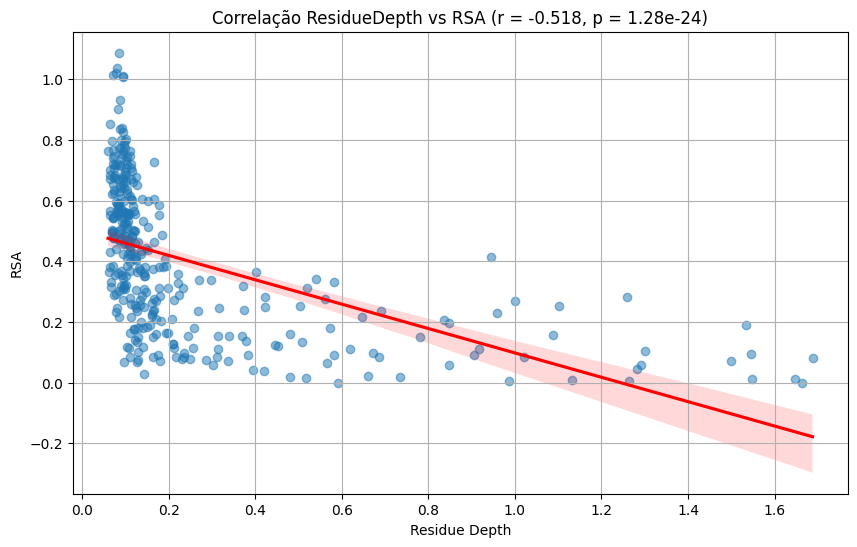

In [19]:
plot_correlation_rsa_depth(merged_df_test, remove_outliers=False)

In [16]:
min_sum_residues

,ResidueNumber,Chain,ResidueDepth,rsa,sum
179,219,L,0.113733,0.030488,0.144221
295,356,L,0.092774,0.056338,0.149112
403,100,M,0.129712,0.040609,0.170321
608,326,M,0.088309,0.082474,0.170783
361,47,M,0.118162,0.053659,0.171820
376,68,M,0.133358,0.040323,0.173680
13,16,L,0.085692,0.097561,0.183253
158,189,L,0.127889,0.055838,0.183727
392,85,M,0.163161,0.021127,0.184288
582,297,M,0.112886,0.072581,0.185467


In [76]:
sel_min_rsa_depth = generate_chimerax_selection(min_rsa_depth) # Cyan
sel_min_rsa_depth

'#1/A:31,113/B:129,133/C:13,17,113/D:23,129,138'

In [77]:
sel_max_rsa_depth = generate_chimerax_selection(max_rsa_depth) # Red
sel_max_rsa_depth

'#1/A:1,19/B:2,52/C:1,19/D:2,52,79,120'

In [97]:
min_sum_residues

,ResidueNumber,Chain,ResidueDepth,rsa,sum
186,24,C,0.095868,0.067568,0.163435
10,13,A,0.141931,0.028302,0.170233
103,37,B,0.110285,0.083700,0.193985
168,2,C,0.127766,0.067073,0.194839
317,105,D,0.129018,0.073171,0.202189
165,145,B,0.104162,0.117117,0.221279
247,133,C,0.108763,0.115385,0.224148
150,118,B,0.128310,0.101523,0.229833
59,92,A,0.164602,0.084677,0.249280
116,57,B,0.180991,0.070064,0.251054


In [86]:
sel_min_sum_residues = generate_chimerax_selection(min_sum_residues) # Cyan
sel_min_sum_residues

'#1/A:13,92/B:37,57,118,145/C:2,24,133/D:105'

In [87]:
sel_max_sum_residues = generate_chimerax_selection(max_sum_residues) # Red
sel_max_sum_residues

'#1/A:26,31,38,113/B:20,35,129/C:6,91/D:37'

In [95]:
sel_max_rsa_min_depth = generate_chimerax_selection(max_rsa_min_depth) # Yellow 
sel_max_rsa_min_depth

'#1/A:1,19/B:52,79,87/C:1,82/D:76,79,95'

In [96]:
sel_max_depth_min_rsa = generate_chimerax_selection(max_depth_min_rsa) #Magenta
sel_max_depth_min_rsa

'#1/A:21,31,113/B:129,133/C:33,76,113/D:129,138'

In [42]:
# Calcular os 10 maiores valores
top_10_maiores = residue_depth.nlargest(60, 'ResidueDepth').reset_index(drop=True)

# Calcular os 10 menores valores
top_10_menores = residue_depth.nsmallest(60, 'ResidueDepth').reset_index(drop=True)

# Calcular a média da coluna ResidueDepth
media = residue_depth['ResidueDepth'].mean()

# Calcular os 10 mais próximos da média
closest_10_media = (
    residue_depth
    .assign(Difference=lambda x: abs(x['ResidueDepth'] - media))  # Criar coluna temporária
    .nsmallest(60, 'Difference')  # Selecionar os 10 mais próximos
    .drop('Difference', axis=1)  # Remover coluna temporária
    .reset_index(drop=True)
)

In [15]:
top_10_maiores

,ResidueNumber,Chain,ResidueDepth
0,6,C,1.687722
1,129,B,1.663157
2,31,A,1.646952
3,113,A,1.547042
4,35,B,1.544685
5,20,B,1.532935
6,37,D,1.498720
7,26,A,1.300743
8,21,A,1.291790
9,33,C,1.282404


In [46]:
top_10_menores


,ResidueNumber,Chain,ResidueDepth
0,76,D,0.059799
1,68,C,0.063070
2,90,C,0.063278
3,80,B,0.063425
4,6,B,0.064188
5,147,B,0.064233
6,77,C,0.064396
7,52,B,0.064540
8,90,D,0.064955
9,118,C,0.065181


In [43]:
selecao_maiores = generate_chimerax_selection(top_10_maiores)
selecao_maiores

'#1/A:6,21,24,26,31,38,48,70,73,81,83,91,98,113,133,137,141/B:7,20,35-36,40,45,70,72,81,100,126,129,133,142/C:6,13-14,17,21,26,33,37,65,73,76,91,113,120-121,127/D:7,15,23,36-37,42,72,108,113,124,129,138,142'

In [44]:
selecao_menores = generate_chimerax_selection(top_10_menores)
selecao_menores

'#1/A:1,8,19,56,60-61,64,71,75,82,90,116/B:6,8,17,22,26,47,49-50,52,62,65,79-80,87,94,104,117,144,147/C:1,5,7,11-12,49,68,72,77,82,89-90,114,118,142/D:5-6,22,43,76,79,90-91,94-95,101,104,139,147'

In [45]:
selecao_media = generate_chimerax_selection(closest_10_media)
selecao_media

'#1/A:9,12,27,30,34,36-37,40,52-53,76,79,89,92,100,112,120-121,127,135,138/B:14,39,55,57,84,96,101,105,125/C:30,36,38,48,52,55,79,83,92,96,98,112,116,130-131,135/D:10,13,20,48,55,70,78,84,88,116-118,121,126'